### FGSM Attack

In [18]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from PIL import Image
import os

In [34]:
epsilon = 0.120
batch_size = 1
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [45]:
imagewoof_path = "../Dataset/Imagewoof/train"
model_path = "../Models/ResNet152.pt"
output_dir = "FGSM"

In [46]:
os.makedirs(output_dir, exist_ok=True)

In [47]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load Imagewoof dataset
dataset = datasets.ImageFolder(root=imagewoof_path, transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

In [48]:
model = torch.jit.load(model_path, map_location=device)
model.to(device).eval()

RecursiveScriptModule(
  original_name=ResNet
  (conv1): RecursiveScriptModule(original_name=Conv2d)
  (bn1): RecursiveScriptModule(original_name=BatchNorm2d)
  (relu): RecursiveScriptModule(original_name=ReLU)
  (maxpool): RecursiveScriptModule(original_name=MaxPool2d)
  (layer1): RecursiveScriptModule(
    original_name=Sequential
    (0): RecursiveScriptModule(
      original_name=Bottleneck
      (conv1): RecursiveScriptModule(original_name=Conv2d)
      (bn1): RecursiveScriptModule(original_name=BatchNorm2d)
      (conv2): RecursiveScriptModule(original_name=Conv2d)
      (bn2): RecursiveScriptModule(original_name=BatchNorm2d)
      (conv3): RecursiveScriptModule(original_name=Conv2d)
      (bn3): RecursiveScriptModule(original_name=BatchNorm2d)
      (relu): RecursiveScriptModule(original_name=ReLU)
      (downsample): RecursiveScriptModule(
        original_name=Sequential
        (0): RecursiveScriptModule(original_name=Conv2d)
        (1): RecursiveScriptModule(original_name=B

In [49]:
# Define loss function
criterion = nn.CrossEntropyLoss()

# Unnormalize transformation for saving images
unnormalize = transforms.Compose([
    transforms.Normalize(mean=[-m/s for m, s in zip([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])],
                         std=[1/s for s in [0.229, 0.224, 0.225]]),
    transforms.ToPILImage(),
])

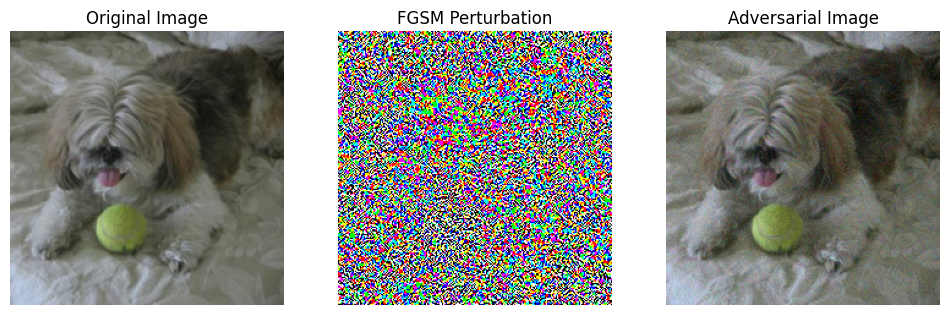

In [50]:
image_tensor, _ = dataset[0]  # First image
image_tensor = image_tensor.unsqueeze(0).to(device)  # Add batch dimension
image_tensor.requires_grad = True

# Forward pass
output = model(image_tensor)
label = output.argmax(dim=1)

# Compute loss and gradients
loss = criterion(output, label)
model.zero_grad()
loss.backward()

# Generate FGSM perturbation
perturbation = epsilon * image_tensor.grad.sign()

# Apply perturbation to create an adversarial image
perturbed_image_tensor = image_tensor + perturbation
# perturbed_image_tensor = torch.clamp(perturbed_image_tensor, 0, 1)

# Convert tensors to images
original_image = unnormalize(image_tensor.squeeze(0).detach().cpu())  # Original image
perturbed_image = unnormalize(perturbed_image_tensor.squeeze(0).detach().cpu())  # Adversarial image

# Normalize perturbation for visualization
perturbation_image = perturbation.squeeze(0).detach().cpu()
perturbation_image = perturbation_image - perturbation_image.min()
perturbation_image = perturbation_image / perturbation_image.max()
perturbation_pil = transforms.ToPILImage()(perturbation_image)

# Plot original, perturbation, and adversarial images
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

axes[0].imshow(original_image)
axes[0].set_title("Original Image")
axes[0].axis("off")

axes[1].imshow(perturbation_pil)
axes[1].set_title("FGSM Perturbation")
axes[1].axis("off")

axes[2].imshow(perturbed_image)
axes[2].set_title("Adversarial Image")
axes[2].axis("off")

plt.show()

In [51]:
# Process each image
for i, (image_tensor, _) in enumerate(dataloader):
    image_tensor = image_tensor.to(device)
    image_tensor.requires_grad = True

    # Forward pass
    output = model(image_tensor)
    label = output.argmax(dim=1)

    # Compute loss and gradients
    loss = criterion(output, label)
    model.zero_grad()
    loss.backward()

    # Generate FGSM perturbation
    perturbation = epsilon * image_tensor.grad.sign()
    perturbed_image_tensor = image_tensor + perturbation

    # Clamp to ensure valid pixel values
    # perturbed_image_tensor = torch.clamp(perturbed_image_tensor, 0, 1)

    # Convert to PIL image
    perturbed_image = unnormalize(perturbed_image_tensor.squeeze(0))

    # Get the class name to rename the folder
    class_folder = dataset.classes[label.item()]
    class_output_folder = os.path.join(output_dir, class_folder)
    os.makedirs(class_output_folder, exist_ok=True)

    # Get original image filename
    original_path, _ = dataset.samples[i]
    filename = os.path.basename(original_path)

    # Save the perturbed image inside the respective class folder
    perturbed_image.save(os.path.join(class_output_folder, filename))

    print(f"Saved: {filename} in {class_output_folder}")

print("FGSM attack completed for all images.")

Saved: ILSVRC2012_val_00000907.JPEG in FGSM/n02086240
Saved: ILSVRC2012_val_00001244.JPEG in FGSM/n02086240
Saved: ILSVRC2012_val_00001393.JPEG in FGSM/n02086240
Saved: ILSVRC2012_val_00002769.JPEG in FGSM/n02086240
Saved: ILSVRC2012_val_00004049.JPEG in FGSM/n02086240
Saved: ILSVRC2012_val_00004359.JPEG in FGSM/n02086240
Saved: ILSVRC2012_val_00004557.JPEG in FGSM/n02086240
Saved: ILSVRC2012_val_00005898.JPEG in FGSM/n02086240
Saved: ILSVRC2012_val_00007958.JPEG in FGSM/n02086240
Saved: ILSVRC2012_val_00008206.JPEG in FGSM/n02086240
Saved: ILSVRC2012_val_00010805.JPEG in FGSM/n02086240
Saved: ILSVRC2012_val_00011754.JPEG in FGSM/n02086240
Saved: ILSVRC2012_val_00011869.JPEG in FGSM/n02086240
Saved: ILSVRC2012_val_00012394.JPEG in FGSM/n02086240
Saved: ILSVRC2012_val_00014174.JPEG in FGSM/n02086240
Saved: ILSVRC2012_val_00015738.JPEG in FGSM/n02086240
Saved: ILSVRC2012_val_00017268.JPEG in FGSM/n02086240
Saved: ILSVRC2012_val_00020379.JPEG in FGSM/n02086240
Saved: ILSVRC2012_val_000219